<h2> Predict Rating based on reviews </h2>
<h4> Recurrent Neural Network (RNN) model with LSTM </h4>

<br/>

<h4> Import Required Packages </h4>

In [1]:
import tensorflow as tf
#test GPU Support
tf.test.is_built_with_cuda()

True

In [2]:
import pandas as pd
from tqdm import tqdm
import neattext.functions as nfx
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from nltk.corpus import stopwords
import nltk
from sklearn.preprocessing import LabelEncoder

<h3>Define Variables </h3>

In [127]:
#max size for vocabulary
vocabulary_size = 5000
#oov token
oov_token = '<OOV>'
#max sequence size for padding
max_size = 100

<h3> Read dataset </h3>

In [4]:
# Read dataset using pandas
dataset = pd.read_csv("data.csv", encoding='utf-8',skipinitialspace=True)
dataset2 = pd.read_csv("data2.csv", encoding='utf-8',skipinitialspace=True)

In [5]:
# Combine Data Sets
dataset = dataset.append(dataset2, ignore_index=True)

#print dataset head
print("Dataset without Preprocessing")
dataset.head()

Dataset without Preprocessing


,id,asins,brand,categories,colors,dateAdded,dateUpdated,dimension,ean,keys,...,reviews.username,sizes,upc,weight,primaryCategories,imageURLs,reviews.dateSeen,reviews.didPurchase,reviews.id,sourceURLs
0,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,2016-03-08T20:21:53Z,2017-07-18T23:52:58Z,169 mm x 117 mm x 9.1 mm,NaN,kindlepaperwhite/b00qjdu3ky,...,Cristina M,NaN,NaN,205 grams,NaN,NaN,NaN,NaN,NaN,NaN
1,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,2016-03-08T20:21:53Z,2017-07-18T23:52:58Z,169 mm x 117 mm x 9.1 mm,NaN,kindlepaperwhite/b00qjdu3ky,...,Ricky,NaN,NaN,205 grams,NaN,NaN,NaN,NaN,NaN,NaN
2,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,2016-03-08T20:21:53Z,2017-07-18T23:52:58Z,169 mm x 117 mm x 9.1 mm,NaN,kindlepaperwhite/b00qjdu3ky,...,Tedd Gardiner,NaN,NaN,205 grams,NaN,NaN,NaN,NaN,NaN,NaN
3,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,2016-03-08T20:21:53Z,2017-07-18T23:52:58Z,169 mm x 117 mm x 9.1 mm,NaN,kindlepaperwhite/b00qjdu3ky,...,Dougal,NaN,NaN,205 grams,NaN,NaN,NaN,NaN,NaN,NaN
4,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,2016-03-08T20:21:53Z,2017-07-18T23:52:58Z,169 mm x 117 mm x 9.1 mm,NaN,kindlepaperwhite/b00qjdu3ky,...,Miljan David Tanic,NaN,NaN,205 grams,NaN,NaN,NaN,NaN,NaN,NaN


In [103]:
# combine columns review title and review text
dataset['review'] = dataset['reviews.title'] + dataset['reviews.text']

# remove unnecessary columns
dataframe = dataset[['review', 'reviews.rating']]

#print dataset head
dataframe.head()

,review,reviews.rating
0,"Paperwhite voyage, no regrets!I initially had ...",5.0
1,One Simply Could Not Ask For MoreAllow me to p...,5.0
2,Great for those that just want an e-readerI am...,4.0
3,Love / Hate relationshipI bought one of the fi...,5.0
4,I LOVE ITI have to say upfront - I don't like ...,5.0


In [104]:
#print dataset size
print("dataset row count before removing null values: "+str(len(dataframe)))

#remove null values 
dataframe = dataframe[dataframe['reviews.rating'].notna()]
dataframe = dataframe[dataframe['review'].notna()]

#print dataset size
print("dataset row count after removing null values: "+str(len(dataframe)))

dataset row count before removing null values: 29929
dataset row count after removing null values: 29509


<h4>This Function is used to clean the dataset </h4>

In [139]:
def clean_review_text(text):
    text_length=[]
    cleaned_text=[]
    for txt in tqdm(text):
        #convert text to lowercase first
        txt=txt.lower()
        #remove special characters from the text
        txt=nfx.remove_special_characters(txt)
        #remove stop words
        txt=nfx.remove_stopwords(txt)
        text_length.append(len(txt.split()))
        cleaned_text.append(txt)
    return cleaned_text,text_length

<h4>Split Data Set into training and validating sets </h4>

In [122]:
train_data,test_data=train_test_split(dataframe,test_size=0.20,random_state=11)
print("Length of Training dataset = {}".format(len(train_data)))
print("Length of Validation dataset = {}".format(len(test_data)))

Length of Training dataset = 23607
Length of Validation dataset = 5902


<h4> Clean text by calling clean_review_text function, </h4>

In [140]:
cleaned_train_text,train_text_length=clean_review_text(train_data.review.astype(str))
cleaned_test_text,test_text_length=clean_review_text(test_data.review.astype(str))

100%|███████████████████████████████████████████████████████████████████████████| 5902/5902 [00:00<00:00, 67247.60it/s]


<h3> Encode Labels </h3>

In [141]:
lbl_target=LabelEncoder()
train_output=lbl_target.fit_transform(train_data['reviews.rating'])
test_output=lbl_target.transform(test_data['reviews.rating'])
print(set(test_data['reviews.rating']))

{1.0, 2.0, 3.0, 4.0, 5.0}


<h4> Tokenize Dataset </h4>

In [125]:
tokenizer=Tokenizer(num_words=vocabulary_size,oov_token=oov_token)
tokenizer.fit_on_texts(cleaned_train_text)
word_index = tokenizer.word_index

<h4> convert dataset into sequences and add padding </h4>

In [128]:
#convert to sequences
train_text_seq=tokenizer.texts_to_sequences(cleaned_train_text)
#add padding
train_text_pad=pad_sequences(train_text_seq,maxlen=max_size,padding='post', truncating='post')
#convert to sequences
test_text_seq=tokenizer.texts_to_sequences(cleaned_test_text)
#add padding
test_text_pad=pad_sequences(test_text_seq,maxlen=max_size,padding='post', truncating='post')
print(train_text_pad[25])

[    8   246  4349   181   287   330   248   862  1560 11833   205   109
   149 11834  1058     3     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0]


In [142]:
print("This is how word index looks like")
dict(list(word_index.items())[0:20])

This is how word index looks like


{'<OOV>': 1,
 'great': 2,
 'batteries': 3,
 'tablet': 4,
 'good': 5,
 'price': 6,
 'use': 7,
 'amazon': 8,
 'love': 9,
 'kindle': 10,
 'fire': 11,
 'like': 12,
 'easy': 13,
 'kids': 14,
 'long': 15,
 'work': 16,
 'buy': 17,
 'bought': 18,
 'product': 19,
 'loves': 20}

<h4> Get vocabulary Size </h4>

In [130]:
vocabulary_size=len(tokenizer.word_index) + 1
print("Size of the Vocabulary = "+str(vocabulary_size))

Size of the Vocabulary = 20458


<h4> Generate a Keras seqeuntial model </h4>

In [131]:
model = tf.keras.Sequential([
    #Embedding layer with vocabulary size and 128 dimension
    tf.keras.layers.Embedding(vocabulary_size, 128),
    #Bidrectional LSTM layer
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
    #Relu dense layer
    tf.keras.layers.Dense(128, activation='relu'),
    #Dropout layer for prevent overfitting
    tf.keras.layers.Dropout(0.4),
    #softmax classifier
    tf.keras.layers.Dense(5, activation='softmax')
])
print("Model Summary")
model.summary()

Model Summary
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, None, 128)         2618624   
_________________________________________________________________
bidirectional_7 (Bidirection (None, 256)               263168    
_________________________________________________________________
dense_14 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 5)                 645       
Total params: 2,915,333
Trainable params: 2,915,333
Non-trainable params: 0
_________________________________________________________________


<h4> compile keras model </h4>

In [132]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

<h4> Train Model </h4>

In [133]:
# max number of epoches
num_epochs = 50
#call back to early stopping
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
#train the model
history = model.fit(train_text_pad, train_output, validation_data=(test_text_pad,test_output), epochs=num_epochs,batch_size=700, callbacks=[es_callback], verbose=1)

Epoch 1/50
34/34 [==============================] - 4s 51ms/step - loss: 1.0189 - accuracy: 0.6833 - val_loss: 0.8323 - val_accuracy: 0.7074
Epoch 2/50
34/34 [==============================] - 1s 37ms/step - loss: 0.7829 - accuracy: 0.7071 - val_loss: 0.7030 - val_accuracy: 0.7247
Epoch 3/50
34/34 [==============================] - 1s 37ms/step - loss: 0.6127 - accuracy: 0.7599 - val_loss: 0.6280 - val_accuracy: 0.7552
Epoch 4/50
34/34 [==============================] - 1s 36ms/step - loss: 0.4764 - accuracy: 0.8209 - val_loss: 0.5936 - val_accuracy: 0.7725
Epoch 5/50
34/34 [==============================] - 1s 38ms/step - loss: 0.3681 - accuracy: 0.8682 - val_loss: 0.5865 - val_accuracy: 0.7914
Epoch 6/50
34/34 [==============================] - 1s 37ms/step - loss: 0.2958 - accuracy: 0.8968 - val_loss: 0.5867 - val_accuracy: 0.8155
Epoch 7/50
34/34 [==============================] - 1s 36ms/step - loss: 0.2459 - accuracy: 0.9164 - val_loss: 0.6046 - val_accuracy: 0.8212
Epoch 8/50
34

<h4> Write the trained model to local stoarge</h4>

In [134]:
model.save("Review_prediction__trained_model.h5")

<h4> Model Validation </h4>

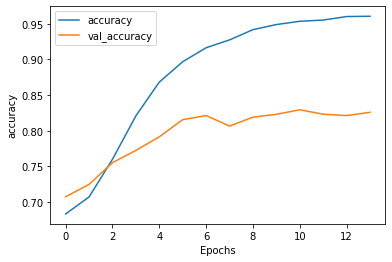

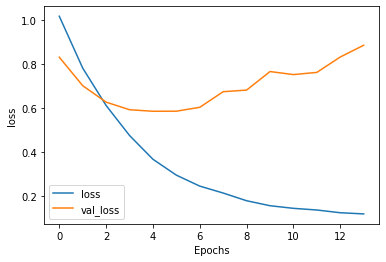

In [143]:
#print accuracy loss plot
import matplotlib.pyplot as plot
def plot_graphs(history, string):
  plot.plot(history.history[string])
  plot.plot(history.history['val_'+string])
  plot.xlabel("Epochs")
  plot.ylabel(string)
  plot.legend([string, 'val_'+string])
  plot.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

<h4> Test with our own sample review texts </h4>

In [144]:
sample_txt = ["They work but they don't last they drain really quickly only had them about 2 weeks and they are almost all dead. Very frustrating will not be buying these again save your money and buy Duracell."]
seq = tokenizer.texts_to_sequences(sample_txt)
padded = pad_sequences(seq, maxlen=max_size,padding='post', truncating='post')
pred = model.predict(padded)
labels = ['1.0', '2.0', '3.0', '4.0', '5.0']
print(pred, labels[np.argmax(pred)])

[[9.9555176e-01 4.4427798e-03 7.0025027e-07 1.5306648e-08 4.7189360e-06]] 1.0


<h4> print Classification Report </h4>

In [138]:
print('TESTING DATA CLASSIFICATION REPORT \n \n')
print(classification_report(test_output,np.argmax(model.predict(test_text_pad), axis=-1),))

TESTING DATA CLASSIFICATION REPORT 
 

              precision    recall  f1-score   support

           0       0.82      0.73      0.77       182
           1       0.47      0.45      0.46       112
           2       0.56      0.60      0.58       255
           3       0.69      0.62      0.65      1178
           4       0.88      0.91      0.90      4175

    accuracy                           0.83      5902
   macro avg       0.68      0.66      0.67      5902
weighted avg       0.82      0.83      0.82      5902

